In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import xarray as xr

import cartopy.crs as ccrs
import cartopy.feature as cfeature

from datetime import datetime
from cartopy.util import add_cyclic_point
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import gc
import glob

from netCDF4 import Dataset

from matplotlib.colors import Normalize
import matplotlib.colors as mcolors
import matplotlib.patheffects as PathEffects
from global_land_mask import globe
import matplotlib.patches as mpatches

import math

In [2]:
path = '/glade/work/noteng/masters-research/data/'

observed_data = 'saved-files1/sum_all_lwe_precip_rate-simulated.nc'
simulated_data = 'saved-files/ensemble-mean1-LAM1km.nc'

observed = xr.open_dataarray(f"{path}{observed_data}")
simulated = xr.open_dataarray(f"{path}{simulated_data}")
# observed = xr.open_dataarray('../lwe_precip/saved-files/sum_all_lwe_precip_rate-simulated.nc')
# simulated = xr.open_dataarray('../LAM1-1km-precip-rate/saved-files/ensemble-mean1-LAM1km.nc')

# mask precip values over land

In [3]:
observed_land = globe.is_land(observed['lat'], observed['lon'])
simulated_land = globe.is_land(simulated['XLAT'], simulated['XLONG'])

In [4]:
observed = observed.where(observed_land, other=0)
simulated = simulated.where(simulated_land, other=0)

### Since the observed domain extends to the far south and simulated domain does not, it is good to cut off the observed southern part before performing the calculations on it

In [5]:
lon_min, lon_max = np.min(simulated['XLONG']).data, np.max(simulated['XLONG']).data
lat_min, lat_max = np.min(simulated['XLAT']).data, np.max(simulated['XLAT']).data

# Mask the data based on longitude and latitude ranges
masked_data_observed = observed.where((observed['lon'] > lon_min) & (observed['lon'] < lon_max) &
                         (observed['lat'] > lat_min) & (observed['lat'] < lat_max), drop=True)

In [6]:
# mask the latitude to match the simulation area
observed = observed.where((observed['lon'] > lon_min) & (observed['lon'] < lon_max) &
                         (observed['lat'] > 67.99) & (observed['lat'] < 71), other=0, drop=True)

In [7]:
np.nanpercentile(masked_data_observed.data, 90), np.nanmean(masked_data_observed.data)

(0.0, 0.11703732)

In [8]:
# masked_data_observed1 = masked_data_observed.copy()
# masked_data_observed1 = masked_data_observed1.where((masked_data_observed1['lon'] >= 10) & (masked_data_observed1['lon'] <= 16.2) & (masked_data_observed1['lat'] >= 68) & (masked_data_observed1['lat'] <= 70), drop=True)
# np.max(masked_data_observed1)

masked_data_observed1 = masked_data_observed.copy()
masked_data_observed1 = masked_data_observed1.where((masked_data_observed1['lon'] >= 15.9) & (masked_data_observed1['lon'] <= 18.005) & (masked_data_observed1['lat'] >= 68.2) & (masked_data_observed1['lat'] <= 70), drop=True)

In [9]:
simulated1 = simulated.copy()
simulated1 = simulated1.where((simulated1['XLONG'] >= 15.9) & (simulated1['XLONG'] <= 18.005) & (simulated1['XLAT'] >= 68.2) & (simulated1['XLAT'] <= 70), drop=True)
np.max(simulated1)

<xarray.DataArray ()>
array(21.598425, dtype=float32)


# calculate the distance between two points using Haversine formula

In [10]:
def haversine_distance(lat1, lon1, lat2, lon2):
    # Convert latitude and longitude from degrees to radians
    lat1 = math.radians(lat1)
    lon1 = math.radians(lon1)
    lat2 = math.radians(lat2)
    lon2 = math.radians(lon2)

    # Radius of the Earth in kilometers
    radius = 6371.0

    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    distance = radius * c

    return distance

## Plot observed vrs simulated

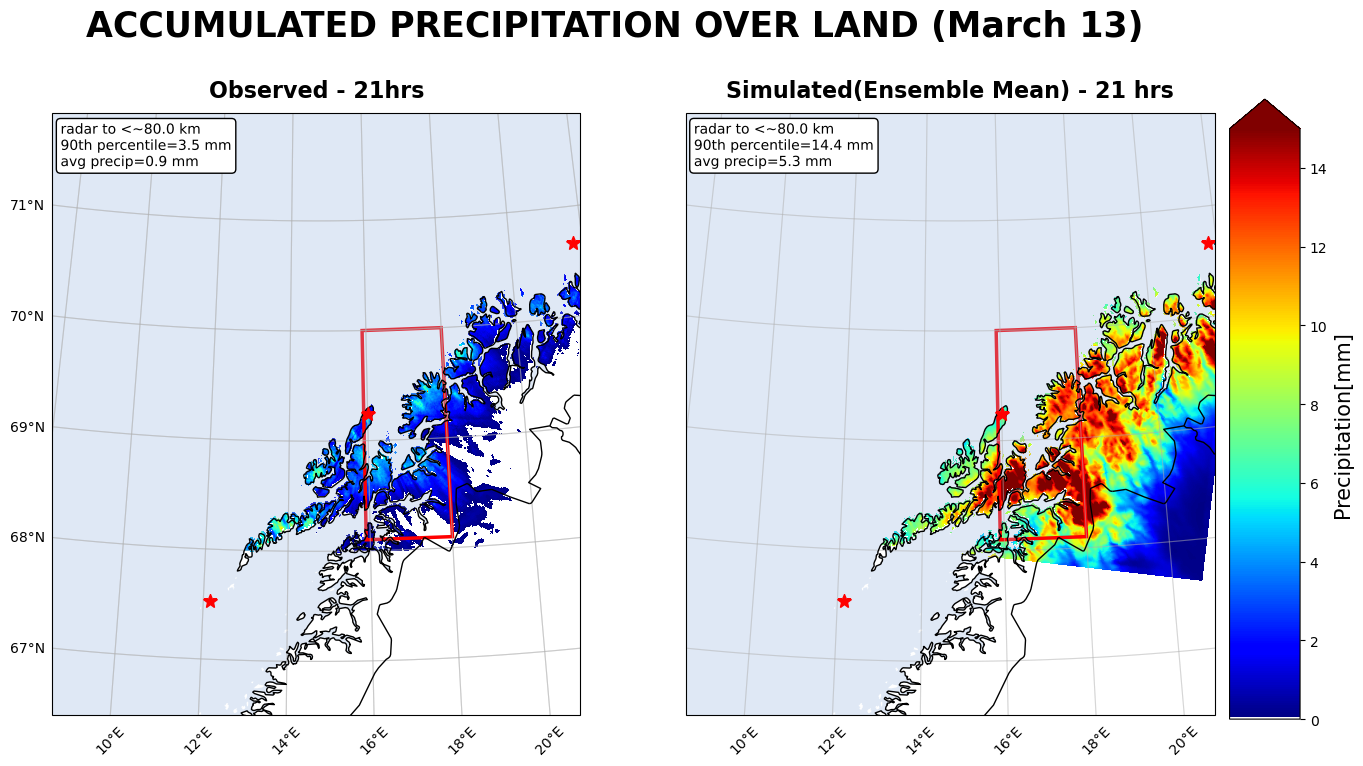

In [11]:
latA = 69.141281  # latitude of COMBLE site
lonA = 15.684166-1  # longitude of COMBLE site -1
xm, ym = 6, 2.75  # extent from center point in lon and lat

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 10), subplot_kw={
                           'projection': ccrs.Orthographic(lonA, latA)})
ax = ax.flatten()

names = ['Observed - 21hrs', 'Simulated(Ensemble Mean) - 21 hrs']

for i, v in enumerate(ax):
    # set extent
    extent = [lonA-xm, lonA+xm, latA-ym, latA+ym]
    ax[i].set_extent(extent)  # set extent of map
    ax[i].set_title(names[i], fontweight='bold', fontsize=16, pad=11)


    # plotting coastlines at a very high resolution: 10m
    ax[i].coastlines(resolution='10m', zorder=7)
    # add borders
    ax[i].add_feature(cfeature.BORDERS, zorder=7)
    # add land
  
    ax[i].add_feature(cfeature.OCEAN, linewidth=1.5, alpha=0.3, zorder=2)
    # add grid lines
    gl = ax[i].gridlines(x_inline=False, alpha=0.3); gl.bottom_labels=False; gl.left_labels=False
    gl.xformatter = LONGITUDE_FORMATTER; gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'rotation': 45}; gl.ylabel_style = {'color': 'black'} 
    # add terrain
    # ax.add_feature(cfeature.GSHHSFeature(scale='high'))
    # Radar locations
    ax[i].plot(16.00297, 69.24139, color='red', marker='*', markersize=10.5,
            transform=ccrs.PlateCarree(), zorder=8)  # plot red star at location of Radar Andoya
    ax[i].plot(12.1544, 67.5264, color='red', marker='*', markersize=10.5,
            transform=ccrs.PlateCarree(), zorder=8)  # plot red star at location at SW
    ax[i].plot(21.7544, 70.664, color='red', marker='*', markersize=10.5,
            transform=ccrs.PlateCarree(), zorder=8)  # plot red star at location at NE
    


# Create the 'jet' colormap
cmap = plt.get_cmap('jet')
# # Modify the colormap
colors = cmap(np.arange(cmap.N))
colors[0] = np.array([1.0, 1.0, 1.0, 1.0])  # change the first color to white
new_cmap = mcolors.LinearSegmentedColormap.from_list("new_jet", colors)

norm = Normalize(vmin=0, vmax=15)
# Create the box around the text
bbox = dict(facecolor='white', edgecolor='black', boxstyle='round')
path_effects = [PathEffects.withStroke(linewidth=1.5, foreground='w')]
    
cs = ax[0].pcolormesh(observed['lon'], 
                   observed['lat'], 
                   observed,
                   transform=ccrs.PlateCarree(),
                   cmap=new_cmap,
                   norm=norm)


# Define the coordinates for your box
min_longitude = 15.9; max_longitude = 18.001
min_latitude = 68.1; max_latitude = 70


# Create a rectangle using mpatches.Rectangle
rectangle = mpatches.Rectangle(
    (min_longitude, min_latitude),  # (x, y) coordinates of the bottom-left corner
    max_longitude - min_longitude,  # Width of the rectangle
    max_latitude - min_latitude,    # Height of the rectangle
    fill=False,                     # Do not fill the rectangle
    edgecolor='red',                # Color of the rectangle's border
    linewidth=2.5,                     # Width of the border line
    transform=ccrs.PlateCarree()
)

# Add the rectangle to the Cartopy axis
ax[0].add_patch(rectangle)


gl = ax[0].gridlines(x_inline=False, alpha=0.3); gl.bottom_labels=False; gl.left_labels=True
gl = ax[0].gridlines(x_inline=False, alpha=0.3); gl.bottom_labels=True; gl.left_labels=False
gl.xlabel_style = {'rotation': 45}

latA1=71.51; lonA1=7.3

# Coordinates of the second point

# Reference point coordinates
ref_latitude = 69.141281
ref_longitude = 15.984166

# Coordinates of the second point
latitude2 = 69.141281
longitude2 = 18.005

# Calculate the distance
distance = haversine_distance(ref_latitude, ref_longitude, latitude2, longitude2)
# print(f"The distance between the reference point and the second point is {distance:.2f} kilometers.")

ax[0].text(lonA1+0.1, latA1-0.15, f'radar to <~{distance:.1f} km\n90th percentile={np.nanpercentile(masked_data_observed1.data, 90):.1f} mm\navg precip={np.nanmean(masked_data_observed1.data):.1f} mm', 
        transform=ccrs.PlateCarree(), color='black', fontsize=10,  bbox=bbox, path_effects=path_effects)

    
cs = ax[1].pcolormesh(simulated['XLONG'], 
                   simulated['XLAT'], 
                   simulated,
                   transform=ccrs.PlateCarree(),
                   cmap=new_cmap,
                   norm=norm
                      )


# Create a rectangle using mpatches.Rectangle
rectangle1 = mpatches.Rectangle(
    (min_longitude, min_latitude),  # (x, y) coordinates of the bottom-left corner
    max_longitude - min_longitude,  # Width of the rectangle
    max_latitude - min_latitude,    # Height of the rectangle
    fill=False,                     # Do not fill the rectangle
    edgecolor='red',                # Color of the rectangle's border
    linewidth=2.5,                     # Width of the border line
    transform=ccrs.PlateCarree()
)

# Add the rectangle to the Cartopy axis
ax[1].add_patch(rectangle1)

gl = ax[1].gridlines(x_inline=False, alpha=0.3); gl.bottom_labels=True; gl.left_labels=False
gl.xlabel_style = {'rotation': 45}


# latA1=71.53; lonA1=7.3
ax[1].text(lonA1+0.08, latA1-0.15, f'radar to <~{distance:.1f} km\n90th percentile={np.nanpercentile(simulated1.data, 90):.1f} mm\navg precip={np.nanmean(simulated1.data):.1f} mm', 
        transform=ccrs.PlateCarree(), color='black', fontsize=10,  bbox=bbox, path_effects=path_effects)


# # # # Add a colorbar axis at the right of the graph
cbar_ax = fig.add_axes([0.91, 0.19, 0.047, 0.62])  # lbwh

cbar = fig.colorbar(cs, cax=cbar_ax, orientation='vertical', extend='max')
cbar.set_label("Precipitation[mm]", fontsize=15)

fig.suptitle('ACCUMULATED PRECIPITATION OVER LAND (March 13)', y=0.90, fontweight='bold', fontsize=25);

fig.savefig('observed-vrs-simulated.png', bbox_inches='tight',dpi=500);

In [12]:
# latA = 69.141281  # latitude of COMBLE site
# lonA = 15.684166-1  # longitude of COMBLE site -1
# xm, ym = 6, 2.75  # extent from center point in lon and lat

# fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 10), subplot_kw={
#                            'projection': ccrs.Orthographic(lonA, latA)})
# ax = ax.flatten()

# names = ['Observed - 21hrs', 'Simulated(Ensemble Mean) - 21 hrs']

# for i, v in enumerate(ax):
#     # set extent
#     extent = [lonA-xm, lonA+xm, latA-ym, latA+ym]
#     ax[i].set_extent(extent)  # set extent of map
#     ax[i].set_title(names[i], fontweight='bold', fontsize=16, pad=11)


#     # plotting coastlines at a very high resolution: 10m
#     ax[i].coastlines(resolution='10m', zorder=7)
#     # add borders
#     ax[i].add_feature(cfeature.BORDERS, zorder=7)
#     # add land
  
#     ax[i].add_feature(cfeature.OCEAN, linewidth=1.5, alpha=0.3, zorder=2)
#     # add grid lines
#     gl = ax[i].gridlines(x_inline=False, alpha=0.3); gl.bottom_labels=False; gl.left_labels=False
#     gl.xformatter = LONGITUDE_FORMATTER; gl.yformatter = LATITUDE_FORMATTER
#     gl.xlabel_style = {'rotation': 45}; gl.ylabel_style = {'color': 'black'} 
#     # add terrain
#     # ax.add_feature(cfeature.GSHHSFeature(scale='high'))
#     # Radar locations
#     ax[i].plot(16.00297, 69.24139, color='red', marker='*', markersize=10.5,
#             transform=ccrs.PlateCarree(), zorder=8)  # plot red star at location of Radar Andoya
#     ax[i].plot(12.1544, 67.5264, color='red', marker='*', markersize=10.5,
#             transform=ccrs.PlateCarree(), zorder=8)  # plot red star at location at SW
#     ax[i].plot(21.7544, 70.664, color='red', marker='*', markersize=10.5,
#             transform=ccrs.PlateCarree(), zorder=8)  # plot red star at location at NE
    


# # Create the 'jet' colormap
# cmap = plt.get_cmap('jet')
# # # Modify the colormap
# colors = cmap(np.arange(cmap.N))
# colors[0] = np.array([1.0, 1.0, 1.0, 1.0])  # change the first color to white
# new_cmap = mcolors.LinearSegmentedColormap.from_list("new_jet", colors)

# norm = Normalize(vmin=0, vmax=15)
# # Create the box around the text
# bbox = dict(facecolor='white', edgecolor='black', boxstyle='round')
# path_effects = [PathEffects.withStroke(linewidth=1.5, foreground='w')]
    
# cs = ax[0].pcolormesh(observed['lon'], 
#                    observed['lat'], 
#                    observed,
#                    transform=ccrs.PlateCarree(),
#                    cmap=new_cmap,
#                    norm=norm)


# # Define the coordinates for your box
# min_longitude = 15.9; max_longitude = 18.001
# min_latitude = 68.1; max_latitude = 70


# # Create a rectangle using mpatches.Rectangle
# rectangle = mpatches.Rectangle(
#     (min_longitude, min_latitude),  # (x, y) coordinates of the bottom-left corner
#     max_longitude - min_longitude,  # Width of the rectangle
#     max_latitude - min_latitude,    # Height of the rectangle
#     fill=False,                     # Do not fill the rectangle
#     edgecolor='red',                # Color of the rectangle's border
#     linewidth=2.5,                     # Width of the border line
#     transform=ccrs.PlateCarree()
# )

# # Add the rectangle to the Cartopy axis
# ax[0].add_patch(rectangle)


# gl = ax[0].gridlines(x_inline=False, alpha=0.3); gl.bottom_labels=False; gl.left_labels=True
# gl = ax[0].gridlines(x_inline=False, alpha=0.3); gl.bottom_labels=True; gl.left_labels=False
# gl.xlabel_style = {'rotation': 45}

# latA1=71.51; lonA1=7.3

# # Coordinates of the second point

# # Reference point coordinates
# ref_latitude = 69.141281
# ref_longitude = 15.984166

# # Coordinates of the second point
# latitude2 = 69.141281
# longitude2 = 18.005

# # Calculate the distance
# distance = haversine_distance(ref_latitude, ref_longitude, latitude2, longitude2)
# # print(f"The distance between the reference point and the second point is {distance:.2f} kilometers.")

# ax[0].text(lonA1+0.1, latA1-0.15, f'radar to <~{distance:.1f} km\n90th percentile={np.nanpercentile(masked_data_observed1.data, 90):.1f} mm\navg precip={np.nanmean(masked_data_observed1.data):.1f} mm', 
#         transform=ccrs.PlateCarree(), color='black', fontsize=10,  bbox=bbox, path_effects=path_effects)

    
# cs = ax[1].pcolormesh(simulated['XLONG'], 
#                    simulated['XLAT'], 
#                    simulated,
#                    transform=ccrs.PlateCarree(),
#                    cmap=new_cmap,
#                    norm=norm
#                       )


# # Create a rectangle using mpatches.Rectangle
# rectangle1 = mpatches.Rectangle(
#     (min_longitude, min_latitude),  # (x, y) coordinates of the bottom-left corner
#     max_longitude - min_longitude,  # Width of the rectangle
#     max_latitude - min_latitude,    # Height of the rectangle
#     fill=False,                     # Do not fill the rectangle
#     edgecolor='red',                # Color of the rectangle's border
#     linewidth=2.5,                     # Width of the border line
#     transform=ccrs.PlateCarree()
# )

# # Add the rectangle to the Cartopy axis
# ax[1].add_patch(rectangle1)

# gl = ax[1].gridlines(x_inline=False, alpha=0.3); gl.bottom_labels=True; gl.left_labels=False
# gl.xlabel_style = {'rotation': 45}


# # latA1=71.53; lonA1=7.3
# ax[1].text(lonA1+0.08, latA1-0.15, f'radar to <~{distance:.1f} km\n90th percentile={np.nanpercentile(simulated1.data, 90):.1f} mm\navg precip={np.nanmean(simulated1.data):.1f} mm', 
#         transform=ccrs.PlateCarree(), color='black', fontsize=10,  bbox=bbox, path_effects=path_effects)


# # # # # Add a colorbar axis at the right of the graph
# cbar_ax = fig.add_axes([0.91, 0.2, 0.047, 0.62])  # lbwh

# cbar = fig.colorbar(cs, cax=cbar_ax, orientation='vertical', extend='max')
# cbar.set_label("Precipitation[mm]", fontsize=15)

# # fig.suptitle('ACCUMULATED PRECIPITATION OVER LAND (March 13)', y=0.90, fontweight='bold', fontsize=25);

# # fig.savefig('observed-vrs-simulated.png', bbox_inches='tight',dpi=500);

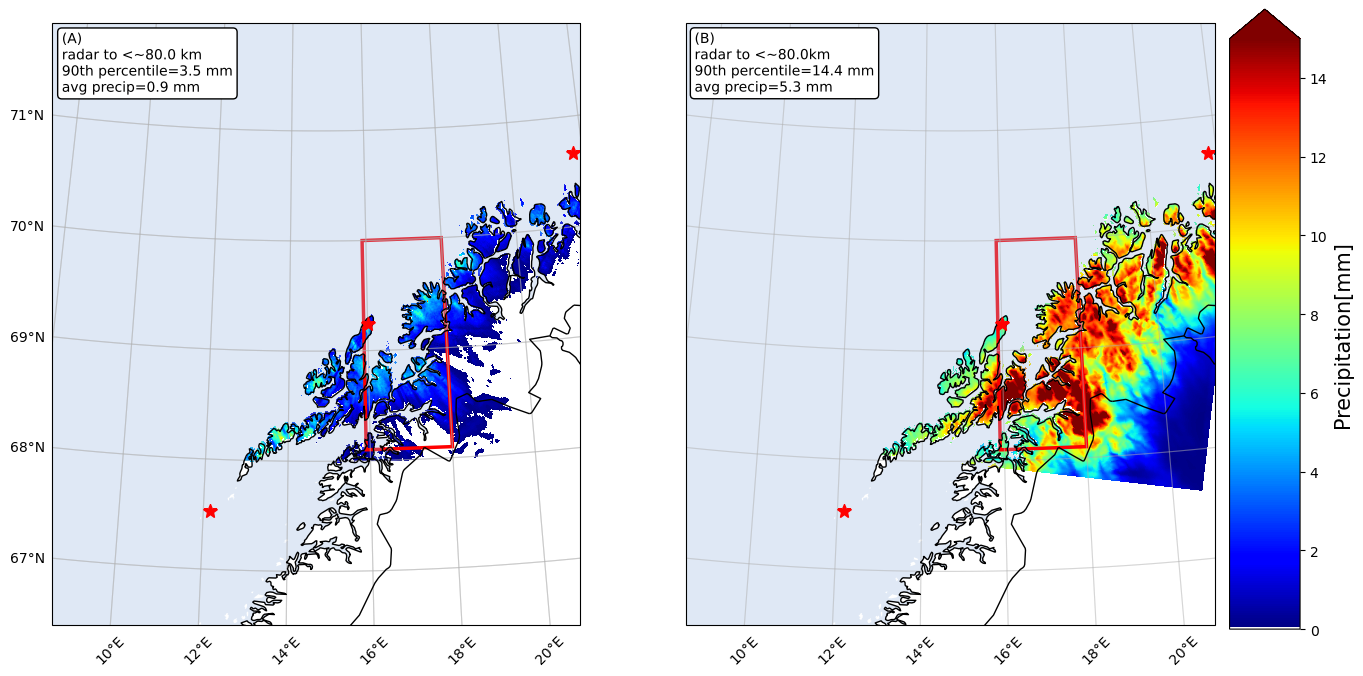

In [13]:
latA = 69.141281  # latitude of COMBLE site
lonA = 15.684166-1  # longitude of COMBLE site -1
xm, ym = 6, 2.75  # extent from center point in lon and lat

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 10), subplot_kw={
                           'projection': ccrs.Orthographic(lonA, latA)})

ax = ax.flatten()

# names = ['Observed - 21hrs', 'Simulated(Ensemble Mean) - 21 hrs']

for i, v in enumerate(ax):
    # set extent
    extent = [lonA-xm, lonA+xm, latA-ym, latA+ym]
    ax[i].set_extent(extent)  # set extent of map
    # ax[i].set_title(names[i], fontweight='bold', fontsize=16, pad=11)


    # plotting coastlines at a very high resolution: 10m
    ax[i].coastlines(resolution='10m', zorder=7)
    # add borders
    ax[i].add_feature(cfeature.BORDERS, zorder=7)
    # add land
  
    ax[i].add_feature(cfeature.OCEAN, linewidth=1.5, alpha=0.3, zorder=2)
    # add grid lines
    gl = ax[i].gridlines(x_inline=False, alpha=0.3); gl.bottom_labels=False; gl.left_labels=False
    gl.xformatter = LONGITUDE_FORMATTER; gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'rotation': 45}; gl.ylabel_style = {'color': 'black'} 
    # add terrain
    # ax.add_feature(cfeature.GSHHSFeature(scale='high'))
    # Radar locations
    ax[i].plot(16.00297, 69.24139, color='red', marker='*', markersize=10.5,
            transform=ccrs.PlateCarree(), zorder=8)  # plot red star at location of Radar Andoya
    ax[i].plot(12.1544, 67.5264, color='red', marker='*', markersize=10.5,
            transform=ccrs.PlateCarree(), zorder=8)  # plot red star at location at SW
    ax[i].plot(21.7544, 70.664, color='red', marker='*', markersize=10.5,
            transform=ccrs.PlateCarree(), zorder=8)  # plot red star at location at NE
    

    


# Create the 'jet' colormap
cmap = plt.get_cmap('jet')
# # Modify the colormap
colors = cmap(np.arange(cmap.N))
colors[0] = np.array([1.0, 1.0, 1.0, 1.0])  # change the first color to white
new_cmap = mcolors.LinearSegmentedColormap.from_list("new_jet", colors)

norm = Normalize(vmin=0, vmax=15)
# Create the box around the text
bbox = dict(facecolor='white', edgecolor='black', boxstyle='round')
path_effects = [PathEffects.withStroke(linewidth=1.5, foreground='w')]
    
cs = ax[0].pcolormesh(observed['lon'], 
                   observed['lat'], 
                   observed,
                   transform=ccrs.PlateCarree(),
                   cmap=new_cmap,
                   norm=norm)


# Define the coordinates for your box
min_longitude = 15.9; max_longitude = 18.001
min_latitude = 68.1; max_latitude = 70


# Create a rectangle using mpatches.Rectangle
rectangle = mpatches.Rectangle(
    (min_longitude, min_latitude),  # (x, y) coordinates of the bottom-left corner
    max_longitude - min_longitude,  # Width of the rectangle
    max_latitude - min_latitude,    # Height of the rectangle
    fill=False,                     # Do not fill the rectangle
    edgecolor='red',                # Color of the rectangle's border
    linewidth=2.5,                     # Width of the border line
    transform=ccrs.PlateCarree()
)

# Add the rectangle to the Cartopy axis
ax[0].add_patch(rectangle)


gl = ax[0].gridlines(x_inline=False, alpha=0.3); gl.bottom_labels=False; gl.left_labels=True
gl = ax[0].gridlines(x_inline=False, alpha=0.3); gl.bottom_labels=True; gl.left_labels=False
gl.xlabel_style = {'rotation': 45}

latA1=71.51; lonA1=7.3

# Reference point coordinates
ref_latitude = 69.141281
ref_longitude = 15.984166

# Coordinates of the second point
latitude2 = 69.141281
longitude2 = 18.005

# Calculate the distance
distance = haversine_distance(ref_latitude, ref_longitude, latitude2, longitude2)
# print(f"The distance between the reference point and the second point is {distance:.2f} kilometers.")

ax[0].text(lonA1+0.19, latA1-0.29, f'(A)\nradar to <~{distance:.1f} km\n90th percentile={np.nanpercentile(masked_data_observed1.data, 90):.1f} mm\navg precip={np.nanmean(masked_data_observed1.data):.1f} mm', 
        transform=ccrs.PlateCarree(), color='black', fontsize=10,  bbox=bbox, path_effects=path_effects)

# Drawing line to achieve the same domain as simulated
# ax[0].plot([8, 15.2], [68.1, 67.97],  transform=ccrs.PlateCarree(), color='red', linestyle='--')

    
cs = ax[1].pcolormesh(simulated['XLONG'], 
                   simulated['XLAT'], 
                   simulated,
                   transform=ccrs.PlateCarree(),
                   cmap=new_cmap,
                   norm=norm
                      )


# Create a rectangle using mpatches.Rectangle
rectangle1 = mpatches.Rectangle(
    (min_longitude, min_latitude),  # (x, y) coordinates of the bottom-left corner
    max_longitude - min_longitude,  # Width of the rectangle
    max_latitude - min_latitude,    # Height of the rectangle
    fill=False,                     # Do not fill the rectangle
    edgecolor='red',                # Color of the rectangle's border
    linewidth=2.5,                     # Width of the border line
    transform=ccrs.PlateCarree()
)

# Add the rectangle to the Cartopy axis
ax[1].add_patch(rectangle1)

gl = ax[1].gridlines(x_inline=False, alpha=0.3); gl.bottom_labels=True; gl.left_labels=False
gl.xlabel_style = {'rotation': 45}


ax[1].text(lonA1+0.15, latA1-0.29, f'(B)\nradar to <~{distance:.1f}km\n90th percentile={np.nanpercentile(simulated1.data, 90):.1f} mm\navg precip={np.nanmean(simulated1.data):.1f} mm', 
        transform=ccrs.PlateCarree(), color='black', fontsize=10,  bbox=bbox, path_effects=path_effects)



# # # # Add a colorbar axis at the right of the graph
cbar_ax = fig.add_axes([0.91, 0.19, 0.047, 0.62])  # lbwh

cbar = fig.colorbar(cs, cax=cbar_ax, orientation='vertical', extend='max')
cbar.set_label("Precipitation[mm]", fontsize=15)


fig.savefig('observed-vrs-simulated-pub.png', bbox_inches='tight',dpi=500);

### _Calculating for biases_

In [14]:
# Bias = M_avg - R_avg
M_avg, R_avg = np.nanmean(simulated1.data), np.nanmean(masked_data_observed1.data)
M_avg, R_avg

(5.321356, 0.92871016)

In [15]:
bias = M_avg - R_avg
bias

4.392646

In [16]:
print(f"Since the bias is positive, it indicates that the model overestimates the precipitation by {bias:.2f} mm")

Since the bias is positive, it indicates that the model overestimates the precipitation by 4.39 mm
